In this part of the project, we create a tool to achieve the following:
1. Our input is an N by N matrix representing a social network with N nodes with 1 or 0 representing the presence or absence of edges.
2. We then construct a graph from the given matrix.
3. Based on the network, we apply the equations for individual infection risk, derive the corresponding equations, and compute a table of probability with infection starting at different nodes.
4. Finally, we take the average infection probability of each node, excluding the case when it is the seed.
5. Depending on the average infection probabilty, we color the network graph with a heatmap color scheme, such that red is the highest infection risk and blue/purple is the lowest infection risk.
6. Our output include: a probability table, a table including all the average infection probability, and a heatmap network for individual infection probability/risk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import numpy as np
import pandas as pd
import os
import sympy as sp

In [ ]:
# Function to generate a random N by N adjacency matrix representing a network without self-loop give number of nodes N
def generate_random_network(N, p=0.3):
    adj_matrix = [[0]*N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            if i != j:
                adj_matrix[i][j] = 1 if random.random() < p else 0
    return adj_matrix

In [ ]:
# Function to generate a network from an N by N adjacency matrix.
def generate_network(adj_matrix):
    G = nx.Graph()
    N = len(adj_matrix)
    for i in range(N):
        for j in range(i+1, N):   # avoid duplicates and self-loops
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)
    return G

In [ ]:
def fixed_point_solver(G, p_val, seed_nodes, tol=1e-9, max_iter=50000):
    """
    Solve for individual attack rates σ_i by fixed-point iteration.

    Args:
        G (nx.Graph or nx.DiGraph): network
        p_val (float): transmission probability
        seed_nodes (list): list of seed node ids
        tol (float): convergence tolerance
        max_iter (int): max number of iterations

    Returns:
        list of σ_i values in node order
    """
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    n = len(nodes)

    # Initialize sigma values
    sigma_vals = np.zeros(n)
    for seed in seed_nodes:
        sigma_vals[node_index[seed]] = 1.0

    # Iteration
    for it in range(max_iter):
        sigma_new = sigma_vals.copy()
        for i_node in nodes:
            i = node_index[i_node]
            if i_node in seed_nodes:
                sigma_new[i] = 1.0
            else:
                neighs = list(G.predecessors(i_node)) if G.is_directed() else list(G.neighbors(i_node))
                if len(neighs) == 0:
                    sigma_new[i] = 0.0
                else:
                    prod_term = 1.0
                    for j in neighs:
                        j_idx = node_index[j]
                        prod_term *= (1 - p_val) * sigma_vals[j_idx]
                    sigma_new[i] = 1 - prod_term

        # Convergence check
        if np.max(np.abs(sigma_new - sigma_vals)) < tol:
            #print(f"Converged in {it} iterations.")
            return sigma_new.tolist()

        sigma_vals = sigma_new

    print("⚠️ Did not converge within max_iter.")
    return sigma_vals.tolist()

In [ ]:
def compute_attack_matrix(G, p_val):
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    n = len(nodes)
    mat = np.zeros((n, n))
    for s in nodes:
        sigma = fixed_point_solver(G, p_val, [s])
        mat[:, node_index[s]] = sigma
    return nodes, mat

def save_attack_csv(nodes, mat, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame(
        mat,
        index=[f"sigma_{i}" for i in nodes],
        columns=[f"Seed {i}" for i in nodes]
    )
    path = os.path.join(outdir, f"individual_attack_rates_p{p_val:.3f}.csv")
    df.to_csv(path, float_format="%.6f")
    return path, df

In [ ]:
# Function to compute the average infection rate by taking the average of the matrix for each row, excluding the 1 value (seed node case)
def compute_average_attack(nodes, mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)   # remove self-seed values
    return np.nanmean(mat_no_diag, axis=1)

def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)

    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })

    path = os.path.join(outdir, f"average_attack_rate_p{p_val:.3f}.csv")
    df.to_csv(path, index=False, float_format="%.6f")

    return path, df

In [ ]:
# Function to visualize the network based on the node index, color the nodes based on a heatmap scale using their average attack rate
def visualize_attack_network(G, nodes, avg_attack, cmap_name="jet"):
    nodes = list(nodes)
    avg_attack = np.asarray(avg_attack)
    attack_dict = {node: avg_attack[i] for i, node in enumerate(nodes)}
    pos = nx.spring_layout(G, seed=42)
    node_colors = [attack_dict[n] for n in G.nodes()]
    vmin = float(np.nanmin(avg_attack))
    vmax = float(np.nanmax(avg_attack))

    plt.figure(figsize=(12, 9))
    nodes_draw = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=plt.get_cmap(cmap_name),
        node_size=80,
        vmin=vmin,
        vmax=vmax
    )
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=0.5)
    nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in G.nodes()}, font_size=6)

    cbar = plt.colorbar(nodes_draw)
    cbar.set_label("Average attack rate")

    plt.axis("off")
    plt.tight_layout()
    plt.savefig("/content/drive/My Drive/Individual_Attack_Rate/individual_attack_network.pdf", dpi=300)
    plt.show()

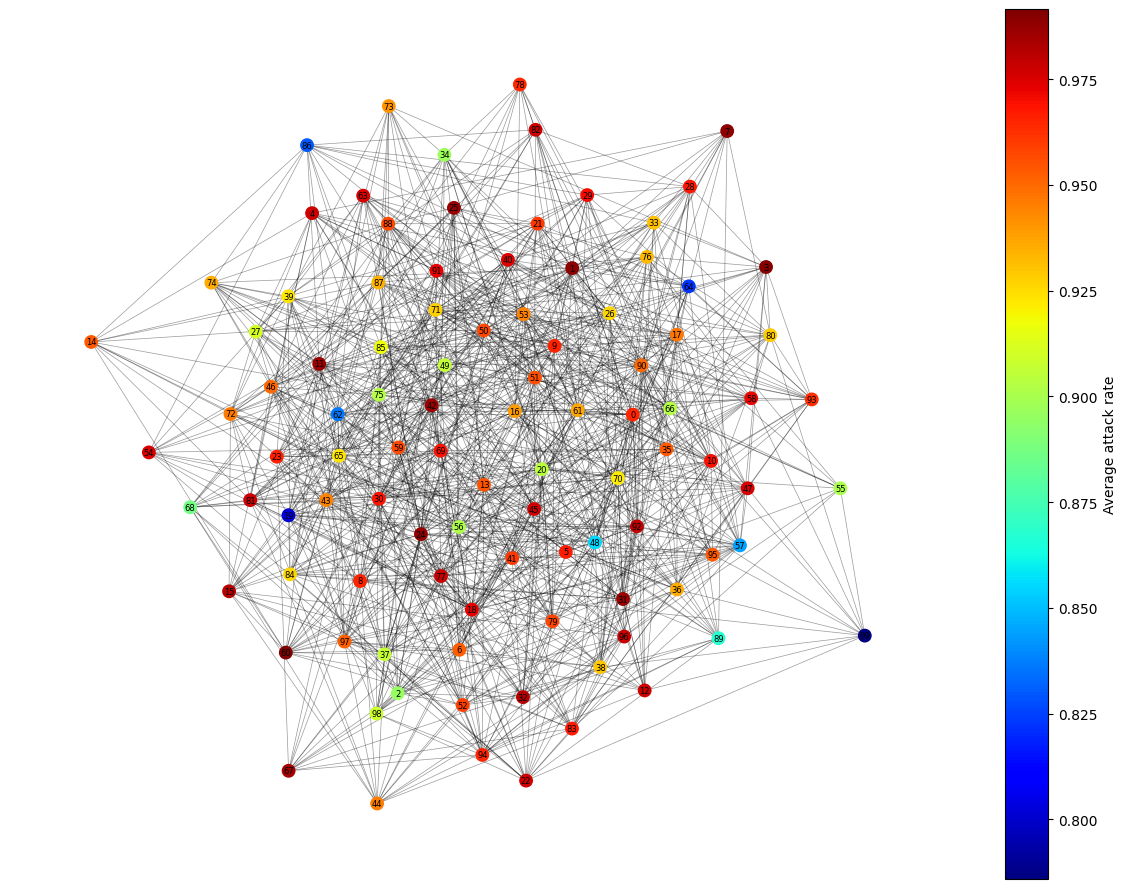

In [ ]:
adj_matrix = generate_random_network(100, 0.2)
with open("/content/drive/My Drive/Individual_Attack_Rate/adj_matrix_100.pkl", "wb") as f:
    pickle.dump(adj_matrix, f)
G = generate_network(adj_matrix)
with open("/content/drive/My Drive/Individual_Attack_Rate/sample_network_1.pkl", "wb") as f:
    pickle.dump(G, f)
nodes, mat = compute_attack_matrix(G, 0.1)
path, df = save_attack_csv(nodes, mat, 0.1)
avg_attack = compute_average_attack(nodes, mat)
path2,df2 = save_average_attack_csv(nodes, avg_attack, 0.1)
visualize_attack_network(G, nodes, avg_attack)

In [ ]:
with open("/content/drive/My Drive/Individual_Attack_Rate/adj_matrix_100.pkl", "rb") as f:
    adj_matrix = pickle.load(f)
with open("/content/drive/My Drive/Individual_Attack_Rate/sample_network_1.pkl", "rb") as f:
    G_loaded = pickle.load(f)

In [ ]:
import pandas as pd
import os

def save_graph_neighbor_csv(G, filename="graph_neighbors.csv"):
    outdir = "/content/drive/My Drive/Individual_Attack_Rate"
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)

    nodes = sorted(G.nodes())
    index_map = {v: i for i, v in enumerate(nodes)}

    data = []
    for v in nodes:
        neigh_indices = [index_map[u] for u in G.neighbors(v)]
        neigh_str = ",".join(str(n) for n in neigh_indices)
        degree = len(neigh_indices)
        data.append([index_map[v], neigh_str, degree])

    df = pd.DataFrame(data, columns=["node", "neighbors", "degree"])
    df.to_csv(path, index=False)

    return path, df

In [ ]:
path3, df3 = save_graph_neighbor_csv(G, "G_neighbors.csv")
print("Saved to:", path3)

Saved to: /content/drive/My Drive/Individual_Attack_Rate/G_neighbors.csv


In [ ]:
import pandas as pd
import os

def rank_nodes_by_attack(csv_path, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    # read the csv
    df = pd.read_csv(csv_path)

    # sort by highest attack rate
    df_ranked = df.sort_values(by="AverageAttackRate", ascending=False).reset_index(drop=True)

    # add rank column (1 = highest infection probability)
    df_ranked["Rank"] = df_ranked.index + 1

    # save new ranked csv
    os.makedirs(outdir, exist_ok=True)
    out_path = os.path.join(outdir, "ranked_" + os.path.basename(csv_path))
    df_ranked.to_csv(out_path, index=False, float_format="%.6f")

    print("\nRanked results:\n")
    print(df_ranked.head())

    return out_path, df_ranked

In [ ]:
csv_path = "/content/drive/My Drive/Individual_Attack_Rate/average_attack_rate_p0.100.csv"

out_path, df_ranked = rank_nodes_by_attack(csv_path)
print("Saved ranked file to:", out_path)


Ranked results:

   Node  AverageAttackRate  Rank
0    60           0.991602     1
1     3           0.990151     2
2     1           0.989003     3
3     7           0.988878     4
4    24           0.987049     5
Saved ranked file to: /content/drive/My Drive/Individual_Attack_Rate/ranked_average_attack_rate_p0.100.csv
